In [1]:
import torch
import torchaudio
from model.audio import resampler, spectogram
from model.config import config
from model.model_audio import AudioEffector
from IPython.display import Audio, display
import pyworld as pw
from training.dataset import load_distorted_sampler
import matplotlib.pyplot as plt

In [2]:
device = "cpu"

#
# Vocoder
#

vocoder = torch.hub.load(repo_or_dir='ex3ndr/supervoice-vocoder', model='bigvsan')
vocoder = vocoder.to(device)
def do_vocoder(src):
    with torch.no_grad():
        return vocoder.generate(src.T.to(torch.float32)).squeeze(0)

#
# Tools
#

def do_spectogram(src):
    return spectogram(src, config.audio.n_fft, config.audio.n_mels, config.audio.hop_size, config.audio.win_size, config.audio.mel_norm, config.audio.mel_scale, config.audio.sample_rate)

def plot_debug(waveform):

    # Preprocess
    spec = do_spectogram(waveform)

    # Display audio
    display(Audio(data=waveform.cpu(), rate=config.audio.sample_rate))

    # Pitch detector
    f0, t0 = pw.dio(waveform.cpu().squeeze(0).numpy().astype('double'), config.audio.sample_rate, frame_period=(1000 * config.audio.hop_size)/config.audio.sample_rate)
    f0 = 2595 * torch.log10(1 + torch.tensor(f0) / 700)
    f0 = f0 / (2595 * torch.log10(torch.tensor(1 + 24000 / 700))) * (100 - 1)

    # Plot
    _, axis = plt.subplots(1, 1, figsize=(20, 5))
    axis.imshow(spec.cpu(), cmap="viridis", vmin=-10, vmax=0, origin="lower", aspect="auto")
    axis.plot(f0, color="white")
    # axis.set_title(title)
    plt.tight_layout()

#
# Dataset
#

sampler = load_distorted_sampler(["./external_datasets/lj-speech-1.1/"], 5, True)

Using cache found in /home/steve/.cache/torch/hub/ex3ndr_supervoice-vocoder_master


In [3]:
# Audio Effector
predictor = AudioEffector(config)
checkpoint = torch.load(f'./output/exp-05.pt', map_location="cpu")
predictor.load_state_dict(checkpoint['model'])
print("Effector at ", checkpoint['step'])

def do_effect(src, steps = 8):
    src = (src - config.audio.norm_mean) / config.audio.norm_std
    pr, _ = predictor.sample(audio = src.to(torch.float32), steps = steps)
    return ((pr * config.audio.norm_std) + config.audio.norm_mean).to(torch.float32)

Effector at  204000


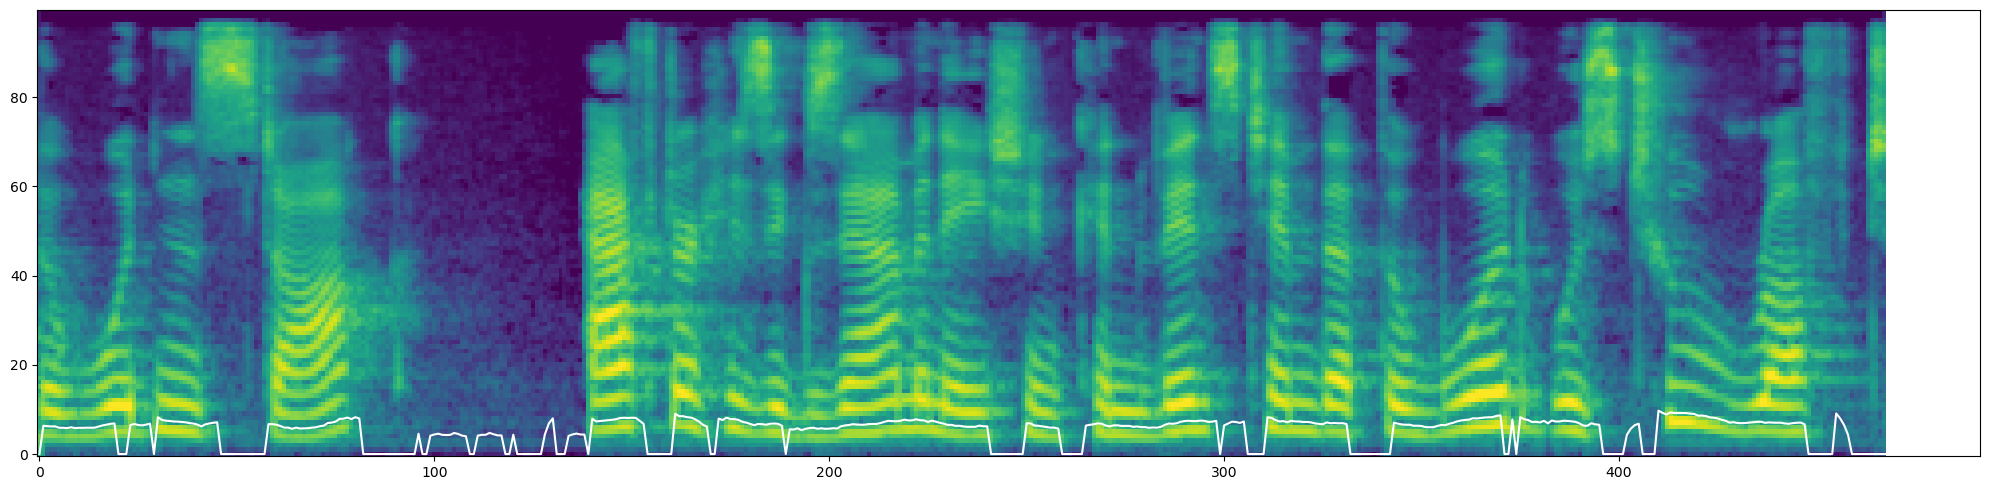

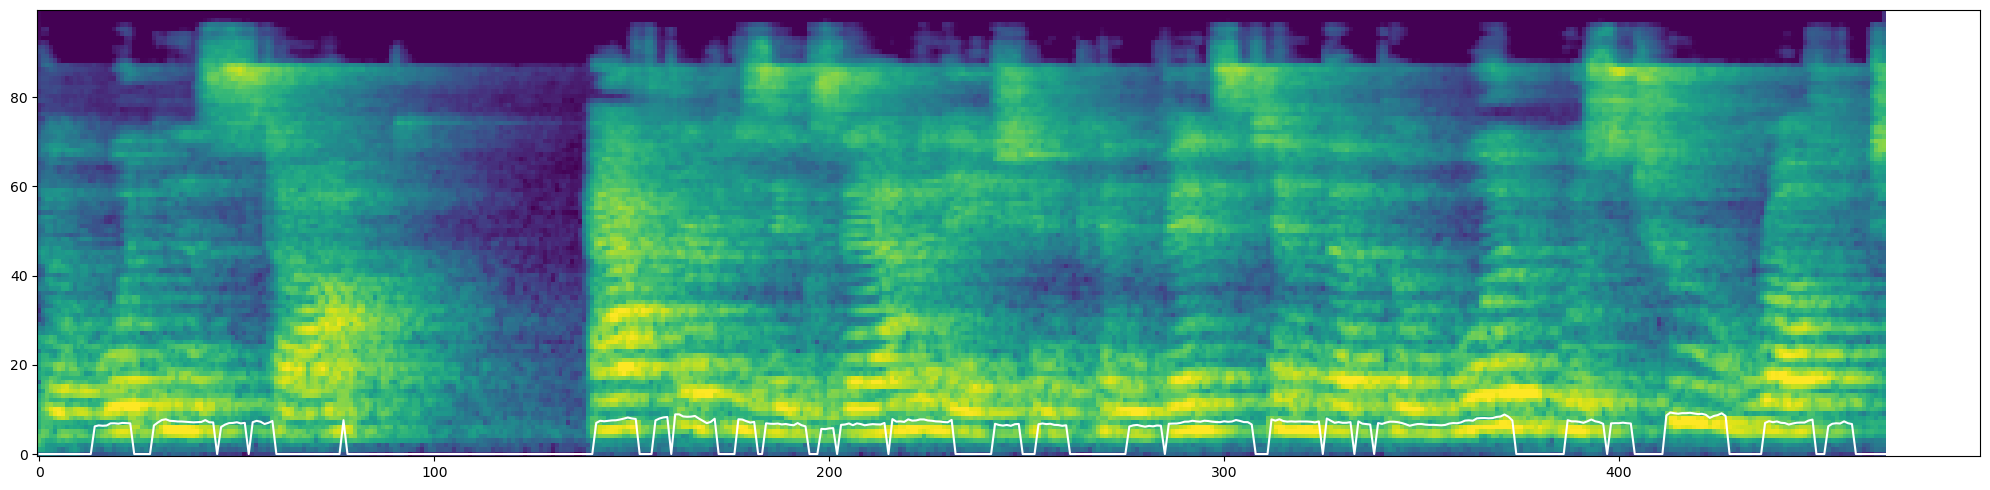

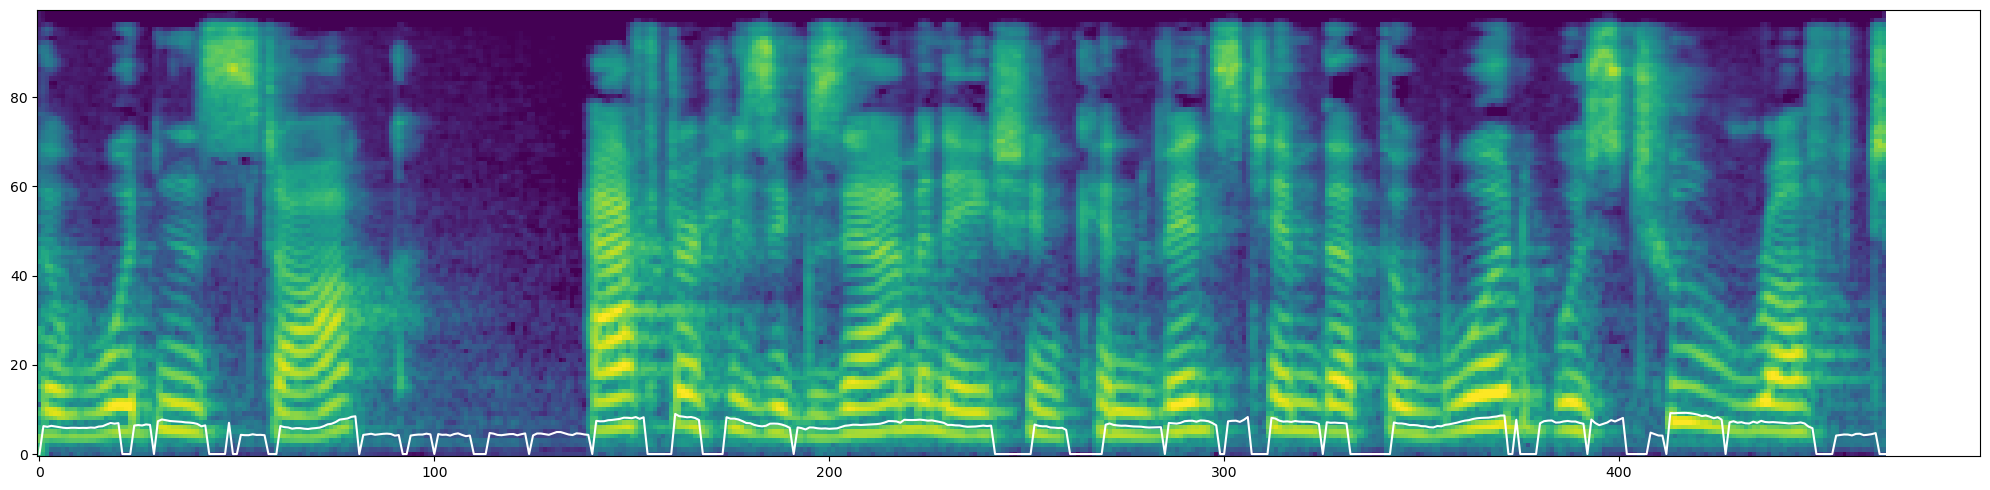

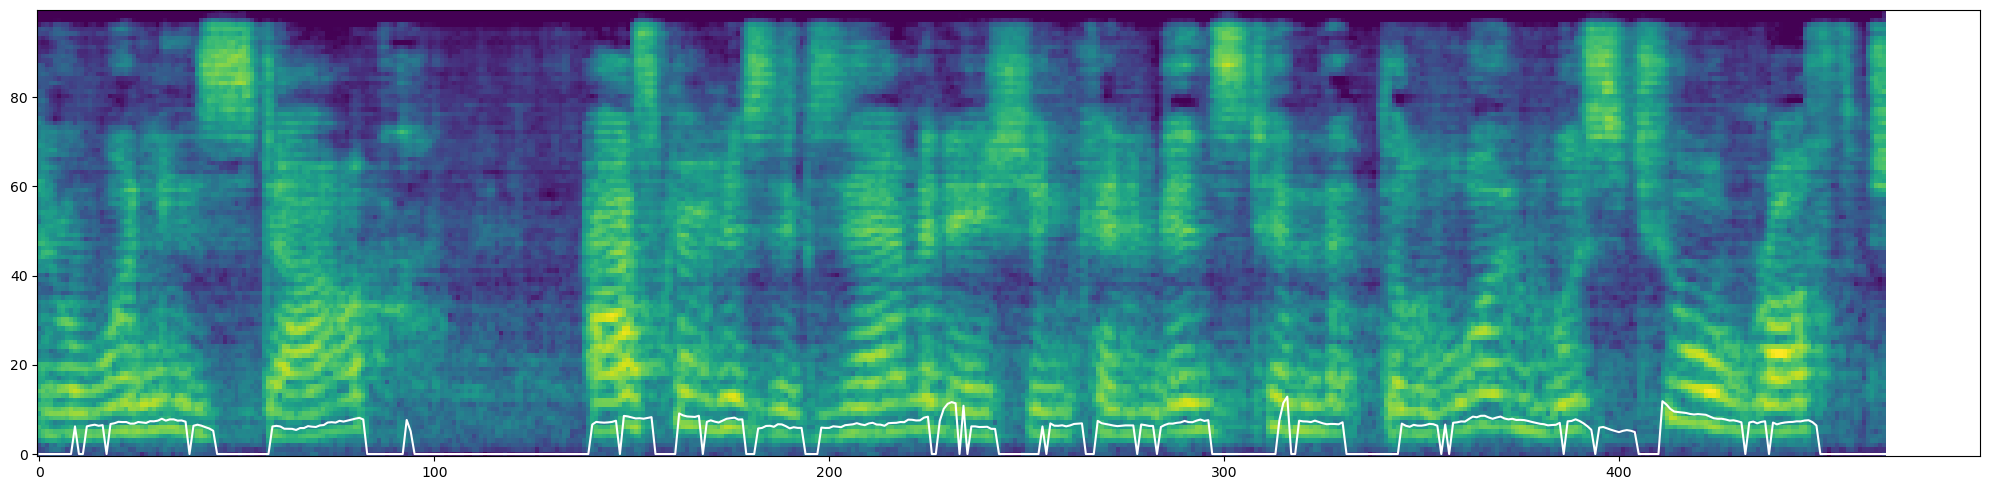

In [4]:
spec, spec_aug, wav, wav_aug = sampler()
spec_processed = do_effect(spec, steps = 4)
wav_aug_2 = do_vocoder(spec)
wav_aug_3 = do_vocoder(spec_processed)
plot_debug(wav)
plot_debug(wav_aug)
plot_debug(wav_aug_2)
plot_debug(wav_aug_3)